In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Mar 27 03:18:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf

import numpy as np
import IPython.display as display

from tensorflow.keras.layers import Layer, Conv2D, Activation, Add, Input, UpSampling2D
from tensorflow.keras.models import Model

In [ ]:
encoder_config = {
    'conv2d_1' : {
                "filters" : 16,
                "kernel_size" : 7,
                "strides" : (1, 1),
                "activation" : "relu",
                "padding" : "same"
            },
    'conv2d_2' : {
                "filters" : 32,
                "kernel_size" : 3,
                "strides" : (2, 2),
                "activation" : "relu",
                "padding" : "same"
            },
    'conv2d_3' : {
                "filters" : 32,
                "kernel_size" : 3,
                "strides" : (1, 1),
                "activation" : "relu",
                "padding" : "same"
            },
    'residual_1' : {
                "channels_in" : 32,
                "kernel_size" : 3
        },
}

manipulator_config = {
    'conv2d_1' : {
                "filters" : 32,
                "kernel_size" : 3,
                "strides" : (1, 1),
                "activation" : "relu",
                "padding" : "same"
            },
    'conv2d_2' : {
                "filters" : 32,
                "kernel_size" : 7,
                "strides" : (1, 1),
                "activation" : "relu",
                "padding" : "same"
            },
    'residual_1' : {
                "channels_in" : 32,
                "kernel_size" : 3
        },
}

decoder_config = {
    "upsampling_1" : {
        "size" : (2,2),
        "interpolation" : "nearest"
    },
    'conv2d_1' : {
                "filters" : 32,
                "kernel_size" : 3,
                "strides" : (1, 1),
                "activation" : "relu",
                "padding" : "same"
            },
    'conv2d_2' : {
                "filters" : 3,
                "kernel_size" : 7,
                "strides" : (1, 1),
                "activation" : "relu",
                "padding" : "same"
            },
    'residual_1' : {
                "channels_in" : 64,
                "kernel_size" : 3
        },
}

In [ ]:
class ResidualBlock(Layer):
    def __init__(self, channels_in, kernel_size, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.trainable = True
        self.channels_in = channels_in
        self.kernel_size = kernel_size

        self.c1 = Conv2D( filters=self.channels_in,
                    kernel_size=self.kernel_size,
                    padding="same"
                  )
        self.c2 = Conv2D( filters=self.channels_in,
                    kernel_size=self.kernel_size,
                    padding="same"
                  )
        self.activation = Activation(activation="relu")
        

    def call(self, x):
        self.first_layer = x
        x = self.c1(x)
        x = self.activation(x)
        x = self.c2(x)
        residual = Add()([x, self.first_layer])
        x = Activation(activation="relu")(residual)

        return x


    def compute_output_shape(self, input_shape):

        return input_shape


class Encoder(tf.keras.layers.Layer):
    def __init__(self, name, network_config, **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.trainable = True
        self.network_config = network_config

        self.c1 = Conv2D(**self.network_config.get('conv2d_1', {}))
        self.c2 = Conv2D(**self.network_config.get('conv2d_2', {}))
        self.c3 = Conv2D(**self.network_config.get('conv2d_2', {}))
        self.c4 = Conv2D(**self.network_config.get('conv2d_3', {}))
        
        self.r1 = ResidualBlock(**self.network_config.get('residual_1', {}))
        self.r2 = ResidualBlock(**self.network_config.get('residual_1', {}))
        self.r3 = ResidualBlock(**self.network_config.get('residual_1', {}))
        self.r4 = ResidualBlock(**self.network_config.get('residual_1', {}))
        self.r5 = ResidualBlock(**self.network_config.get('residual_1', {}))
        self.r6 = ResidualBlock(**self.network_config.get('residual_1', {}))
        self.r7 = ResidualBlock(**self.network_config.get('residual_1', {}))
    
    def call(self, x): 
        texture_repr, shape_repr = None, None

        x = self.c1(x)
        x = self.c2(x)
        x = self.r1(x)
        x = self.r2(x)
        x = self.r3(x)
        
        texture_repr = self.c3(x)
        x = self.r4(x)
        x = self.r5(x)
        
        shape_repr = self.c4(x)
        x = self.r6(x)
        x = self.r7(x)

        return texture_repr, shape_repr

class Manipulator(Layer):
    def __init__(self, network_config, **kwargs):
        super(Manipulator, self).__init__(name="Manipulator", **kwargs)
        self.trainable = True
        self.network_config = network_config

        self.c1 = Conv2D(**self.network_config.get('conv2d_1', {}))
        self.c2 = Conv2D(**self.network_config.get('conv2d_1', {}))

        self.r1 = ResidualBlock(**self.network_config.get('residual_1', {}))

    def call(self, shape_repr_frameA, shape_repr_frameB, amplification_factor):
        shape_repr_frameB = tf.math.subtract(shape_repr_frameB, shape_repr_frameA)
        shape_repr_frameB = self.c1(shape_repr_frameB)
        shape_repr_frameB = shape_repr_frameB * amplification_factor
        shape_repr_frameB = self.c2(shape_repr_frameB)
        shape_repr_frameB = self.r1(shape_repr_frameB)
        
        x = tf.math.add(shape_repr_frameA, shape_repr_frameB)

        return x


class Decoder(Layer):
    def __init__(self, network_config, **kwargs):
        super(Decoder, self).__init__(name="Decoder", **kwargs)
        self.trainable = True
        self.network_config = network_config

        self.us1 = UpSampling2D(**self.network_config.get('upsampling_1', {}))
        self.us2 = UpSampling2D(**self.network_config.get('upsampling_1', {}))

        self.c1 = Conv2D(**self.network_config.get('conv2d_1', {}))
        self.c2 = Conv2D(**self.network_config.get('conv2d_2', {}))

        self.r1 = ResidualBlock(**self.network_config.get('residual_1', {}))
        self.r2 = ResidualBlock(**self.network_config.get('residual_1', {}))
        self.r3 = ResidualBlock(**self.network_config.get('residual_1', {}))
        self.r4 = ResidualBlock(**self.network_config.get('residual_1', {}))
        self.r5 = ResidualBlock(**self.network_config.get('residual_1', {}))
        self.r6 = ResidualBlock(**self.network_config.get('residual_1', {}))
        self.r7 = ResidualBlock(**self.network_config.get('residual_1', {}))
        self.r8 = ResidualBlock(**self.network_config.get('residual_1', {}))
        self.r9 = ResidualBlock(**self.network_config.get('residual_1', {}))

    def call(self, texture_repr, shape_repr):
        texture_repr = self.us1(texture_repr)
        x = tf.concat([texture_repr, shape_repr], axis = 3)
        x = self.r1(x)
        x = self.r2(x)
        x = self.r3(x)
        x = self.r4(x)
        x = self.r5(x)
        x = self.r6(x)
        x = self.r7(x)
        x = self.r8(x)
        x = self.r9(x)
        x = self.us2(x)
        x = self.c1(x)
        x = self.c2(x)
    
        return x

In [ ]:
class MotionDetectionModel(Model):
    def __init__(self):
        super(MotionDetectionModel, self).__init__()        
        self.amplification_factor = Input(shape = (1,1,1))
        self.encoder = Encoder(network_config=encoder_config, name="Encoder")
        self.manipulator = Manipulator(network_config=manipulator_config)
        self.decoder = Decoder(network_config=decoder_config)

    def call(self, inputs):
        input_frameA = inputs[0]
        input_frameB = inputs[1]
        input_amplification_factor = inputs[2]

        print(type(input_frameA), type(input_frameB), type(input_amplification_factor))
        _, shape_repr_frameA = self.encoder(input_frameA)
        texture_repr_frameB, shape_repr_frameB = self.encoder(input_frameB)

        shape_repr_manipulator = self.manipulator(shape_repr_frameA, shape_repr_frameB, input_amplification_factor)
        output = self.decoder(texture_repr_frameB, shape_repr_manipulator)
        return output

    def build_graph(self, img_raw_shape, amp_factor_raw_shape):
        frameA = Input(shape=img_raw_shape)
        frameB = Input(shape=img_raw_shape)
        amplied = Input(shape=img_raw_shape)
        amplification_factor = Input(shape = amp_factor_raw_shape)
        return Model(inputs=[frameA, frameB, amplification_factor], outputs=self.call([frameA, frameB, amplification_factor]))

In [ ]:
def create_model():
    frameA  = Input(shape=(384,384,3))
    frameB = Input(shape=(384,384,3))
    amp_factor = Input(shape = (1,1,1))
    enc = Encoder(name="Encoder", network_config=encoder_config)
    # enc = encoder(network_config=encoder_config)
    texture_A , shape_A  = enc(frameA)
    texture_B , shape_B = enc(frameB)
    shape_B = Manipulator(network_config=manipulator_config)(shape_A,shape_B,amp_factor)
    out = Decoder(network_config=decoder_config)(texture_B,shape_B)
    model = Model(inputs = [frameA,frameB,amp_factor], outputs = out)
    return model

In [ ]:
img_raw_shape = (384,384,3)
amp_factor_raw_shape = (1, 1, 1)

# model = MotionDetectionModel()
# model([tf.ones(shape=(0,*img_raw_shape)), tf.ones(shape=(0,*img_raw_shape)), tf.ones(shape=(0,*amp_factor_raw_shape))])
# model.build_graph(img_raw_shape, amp_factor_raw_shape).summary()

model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_1 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 Encoder (Encoder)              ((None, 96, 96, 32)  154976      ['input_1[0][0]',                
                                , (None, 192, 192,                'input_2[0][0]']            

In [ ]:
from google.colab import drive

In [ ]:
BASE_DIR = "/content/drive/My Drive/motion_detection/data"
FRAME_A_FOLDER = 'frameA_10k'
FRAME_B_FOLDER = 'frameB_10k'
FRAME_C_FOLDER = 'frameC_10k'
AMPLIFIED_FOLDER = 'amplified_10k'
META_JSON_FOLDER = 'metadata_10k'
IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS = 384, 384, 3

drive.mount('/content/drive')
# !ls "/content/drive/My Drive"
%cd $BASE_DIR

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/motion_detection/data


# New Section

In [ ]:
!cp -rf /content/drive/MyDrive/motion_detection/data /content/dataset/

In [ ]:
BASE_DIR = "/content/dataset"

In [ ]:
import glob
import os
import random
import json
import cv2
from tqdm import tqdm

from tensorflow.keras.utils import Sequence
import pandas as pd

In [ ]:
train_filenames_path = '/content/dataset/train_filenames.txt'
validation_filenames_path = '/content/dataset/validation_filenames.txt'

def get_filenames(filepath):
    lines = []
    with open(filepath) as f:
        lines = f.readlines()
    lines = [x.strip() for x in lines]
    return lines

train_filenames = get_filenames(train_filenames_path)
val_filenames = get_filenames(validation_filenames_path)
len(train_filenames), len(val_filenames)

(8000, 2000)

In [ ]:
npz_filepath = '/content/drive/MyDrive/motion_detection/npz_v2'
train_df_lst  = []
val_df_lst = []


def read_image(filepath):
    pic_bgr_arr = cv2.imread(filepath)
    pic_rgb_arr = cv2.cvtColor(pic_bgr_arr, cv2.COLOR_BGR2RGB)
    return pic_rgb_arr/255
    # return pic_rgb_arr

def get_amplification_value(filepath):
    print(filepath)
    i = json.load(open(filepath))['amplification_factor']
    return np.array(np.reshape([i], (1, 1, 1)), dtype=np.float)

def generate_data(location, filenames, name='train'):
    npz_paths = []
    for filename in tqdm(filenames, desc='Generating {} data...'.format(name)):
        npz_path = filename.split('.')[0] + '.npz'
        npz_path = os.path.join(location, name, npz_path)
        npz_paths.append(npz_path)
        if not os.path.exists(npz_path):
            frame_A = read_image(os.path.join(BASE_DIR, FRAME_A_FOLDER, filename))
            # frame_B = read_image(os.path.join(BASE_DIR, FRAME_B_FOLDER, filename))
            frame_C = read_image(os.path.join(BASE_DIR, FRAME_C_FOLDER, filename))
            y = read_image(os.path.join(BASE_DIR, AMPLIFIED_FOLDER, filename))
            mf = get_amplification_value(os.path.join(BASE_DIR, META_JSON_FOLDER, '{}.json'.format(os.path.splitext(filename)[0])))
            np.savez_compressed(npz_path, frameA=frame_A, 
                                # frameB=frame_B, 
                                frameC=frame_C, amp_y=y, mf=mf)
    npz_df = pd.DataFrame(npz_paths, columns=['npz_filepath'])
    npz_df.to_csv(os.path.join(location, 'npz_{}.csv'.format(name)), index=False)
    _df = pd.read_csv(os.path.join(location, 'npz_{}.csv'.format(name)))
    print("\n Shape", _df.shape)
    print(_df.head())


In [ ]:
train_filenames[:5]

['009962.png', '008945.png', '002921.png', '000672.png', '006497.png']

In [ ]:
# generate_data(npz_filepath, train_filenames[:1], name='train')
# generate_data(npz_filepath, val_filenames, name='val')


In [ ]:
def data_generator(df, batch_size):    
    samples_per_epoch = df.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    while 1:
        X_frameA, X_frameB, X_mf, y_amplified = [], [], [], []
        for name in df['npz_filepath'].iloc[counter*batch_size:batch_size*(counter+1)]:
            loaded_npz = np.load(name)
            X_frameA.append(loaded_npz['frameA'])
            X_frameB.append(loaded_npz['frameC'])
            X_mf.append(loaded_npz['mf'])
            y_amplified.append(loaded_npz['amp_y'])
        X_frameA, X_frameB, X_mf, y_amplified = np.array(X_frameA), np.array(X_frameB), np.array(X_mf), np.array(y_amplified)
        counter += 1   
        yield [X_frameA, X_frameB, X_mf], y_amplified
        if counter >= number_of_batches:
            counter = 0


# def get_Xy(df):
#     X_frameA, X_frameB, X_mf, y_amplified = [], [], [], []
#     for name in df['npz_filepath']:
#         loaded_npz = np.load(name)
#         X_frameA.append(loaded_npz['frameA'])
#         X_frameB.append(loaded_npz['frameC'])
#         X_mf.append(loaded_npz['mf'])
#         y_amplified.append(loaded_npz['amp_y'])
#     X_frameA, X_frameB, X_mf, y_amplified = np.array(X_frameA), np.array(X_frameB), np.array(X_mf), np.array(y_amplified)   
#     return (X_frameA, X_frameB, X_mf), y_amplified


# def get_Xy(df):
#     inputs, outputs = [], []
#     for name in df['npz_filepath']:
#         loaded_npz = np.load(name)
#         input = []
#         input.append(loaded_npz['frameA'])
#         input.append(loaded_npz['frameC'])
#         input.append(loaded_npz['mf'])
#         inputs.append(input)
#         outputs.append(loaded_npz['amp_y'])
#     return inputs, outputs

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/motion_detection/npz/npz_train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/motion_detection/npz/npz_val.csv')

In [ ]:
# train_df = pd.read_csv('/content/drive/MyDrive/motion_detection/npz/npz_train.csv')
# (X_train_frameA, X_train_frameB, X_train_mf), y_train_amplified = get_Xy(train_df[:1000])
# X_train, y_train = get_Xy(train_df)
# train_df['npz_filepath'].iloc[2:4]

In [ ]:
# X_train_frameA.shape, X_train_frameB.shape, X_train_mf.shape, y_train_amplified.shape

In [ ]:
# val_df = pd.read_csv('/content/drive/MyDrive/motion_detection/npz/npz_val.csv')
# (X_val_frameA, X_val_frameB, X_val_mf), y_val_amplified = get_Xy(val_df[:100])
# X_val, y_val = get_Xy(val_df)

In [ ]:
# X_val_frameA.shape, X_val_frameB.shape, X_val_mf.shape, y_val_amplified.shape

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

model.compile(loss='mse', optimizer=optimizer, metrics=['mean_absolute_error'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

cp = ModelCheckpoint('/content/drive/MyDrive/motion_detection/model/v3/', save_best_only=True, verbose=1, mode='auto', period=1)
batch_size = 8

# model.fit_generator(
#     data_generator(train_df,batch_size),
#     epochs=10,
#     steps_per_epoch = train_df.shape[0]/batch_size,
#     validation_data = data_generator(val_df,batch_size*2),
#     validation_steps = train_df.shape[0]/batch_size*2,
#     callbacks=[cp]
# )

# model.fit(x=[X_train_frameA, X_train_frameB, X_train_mf], 
#           y=y_train_amplified, 
#           validation_data=([X_val_frameA, X_val_frameB, X_val_mf], y_val_amplified), 
#           batch_size=10,
#           epochs=2, 
#           callbacks=[cp])

# model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=2, callbacks=[cp])

In [ ]:
import tensorflow.keras as keras
model = keras.models.load_model('/content/drive/MyDrive/motion_detection/model/v2/')

In [ ]:
model

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
test_gen = data_generator(val_df,1)
X, y = next(test_gen)


In [ ]:
for x in X:
    print(x.shape)
print(y.shape)

(1, 384, 384, 3)
(1, 384, 384, 3)
(1, 1, 1, 1)
(1, 384, 384, 3)


In [ ]:
X[2]

array([[[[55.76395437]]]])

In [ ]:
out = model.predict([X])

In [ ]:
y[0].shape, out[0].shape

((384, 384, 3), (384, 384, 3))

In [ ]:
np.amax(out[0])

1.2084045

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


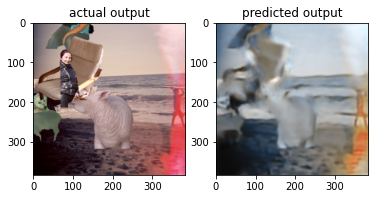

In [ ]:
plt.subplot(1,2,1)
plt.title(label ='actual output')
plt.imshow(y[0])
plt.subplot(1,2,2)
plt.title(label ='predicted output')
plt.imshow(out[0])

In [ ]:
def extractImages(pathIn, pathOut):
    count = 0
    vidcap = cv2.VideoCapture(pathIn)
    success,image = vidcap.read()
    success = True
    while success:
        # vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*1000))    # added this line 
        success,image = vidcap.read()
        print ('Read a new frame: ', success)
        cv2.imwrite( pathOut + "\\frame%d.jpg" % count, image)     # save frame as JPEG file
        count = count + 1

In [ ]:
# extractImages('/content/drive/MyDrive/motion_detection/video/baby.mp4', '/content/drive/MyDrive/motion_detection/video/baby_v1')

In [ ]:
def generateVideo(images, outputpath, width=384, height=384):
    fourcc=cv2.VideoWriter_fourcc('X', 'V', 'I', 'D')
    video = cv2.VideoWriter(outputpath, fourcc, float(60), (width, height))
    for image in images:
        image = (image*255).astype(np.uint8)
        video.write(image)
    cv2.destroyAllWindows() 
    video.release()

In [ ]:
image_base_path = '/content/drive/MyDrive/motion_detection/video/baby_v1\\'
i = 0
image_path = '{}frame{}.jpg'.format(image_base_path, i)
in_images = []
while os.path.exists(image_path):
    pic_bgr_arr = cv2.imread(image_path)
    pic_rgb_arr = cv2.cvtColor(pic_bgr_arr, cv2.COLOR_BGR2RGB)
    pic_rgb_arr = cv2.resize(pic_rgb_arr, (384, 384), interpolation = cv2.INTER_AREA)
    pic_rgb_arr = pic_rgb_arr/255
    in_images.append(pic_rgb_arr)
    i = i+1
    image_path = '{}frame{}.jpg'.format(image_base_path, i)


In [ ]:
out_images = []
mf = np.array(np.reshape([30], (1, 1, 1, 1)), dtype=np.float)
for i in range(1, len(in_images)):
    frameA = np.array([in_images[i-1]])
    frameB = np.array([in_images[i]])
    X = [frameA, frameB, mf]
    # print(frameA.shape, frameB.shape, mf.shape)
    out = model.predict([X])
    out_images.append(out[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
final_video_path = '/content/drive/MyDrive/motion_detection/final/baby_v1.avi'
generateVideo(out_images, final_video_path)

299